# SCVI Tech integration and label transfer

In [1]:
!date

Mon Oct 21 13:38:23 PDT 2024


In [2]:
!echo $CONDA_PREFIX

/c4/home/derek/miniconda3/envs/SCVI


In [3]:
##notebook based on https://docs.scvi-tools.org/en/stable/tutorials/notebooks/tabula_muris.html

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scvi

# sc.set_figure_params(figsize=(4, 4))

# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# %config InlineBackend.figure_format='retina'

/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#set seeds for reproducibility 
import torch
random_seed = 1
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [6]:
torch.cuda.is_available()

True

In [7]:

#first, process the SMART-seq data#


In [8]:
adata_SS2 = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/NOW_2017_SS2/SS2.h5ad') #Solo_outs_hp3ref/Solo.out/GeneFull/raw/
adata_SS2.var_names = adata_SS2.var_names.astype('str')

adata_SS2.var_names_make_unique()

/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
adata_SS2.obs.insert(0,'batch','6')

In [10]:
adata_SS2.obs['tech'] = 'SS2'

In [11]:
# input_dir = '/home/derek/analysis_2/SLR_temp/GW23_1/merged/StarOut_internal/Solo.out/GeneFull/raw/'

# adata_SLR = sc.read_mtx(input_dir+ 'matrix.mtx').T
# adata_SLR.obs_names = pd.read_csv(input_dir+'barcodes.tsv',header=None)[0]
# adata_SLR.var_names = pd.read_csv(input_dir+'features.tsv',header=None,sep='\t')[1]

adata_SLR = sc.read_h5ad('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/SCVI.h5ad')

In [12]:
adata_SLR.var_names_make_unique()

In [13]:
adata_SLR.obs['tech'] = 'SLR'

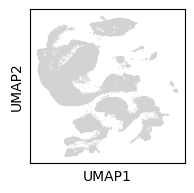

In [14]:
plt.rcParams['figure.figsize']=2,2
sc.pl.umap(adata_SLR)
           

In [15]:
#sc.pp.filter_cells(adata_SLR,min_genes=2000)

In [16]:
adata_SLR = adata_SLR.raw.to_adata().copy()

In [17]:
adata_SS2_ = adata_SS2[:,adata_SS2.var_names.isin(adata_SLR.var_names)].copy()

In [18]:
adata = adata_SLR.concatenate(adata_SS2, batch_key='tech', batch_categories=['SLR','SS2'])

/scratch/derek/ipykernel_3790177/2473166920.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_SLR.concatenate(adata_SS2, batch_key='tech', batch_categories=['SLR','SS2'])


In [19]:
adata

AnnData object with n_obs × n_vars = 79927 × 36344
    obs: 'n_counts', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden', 'scANVI_simple', 'tech', 'WGCNAcluster', 'Name', 'Age_in_Weeks', 'RegionName', 'Laminae', 'Area'
    var: 'mito-SLR', 'n_cells_by_counts-SLR', 'mean_counts-SLR', 'log1p_mean_counts-SLR', 'pct_dropout_by_counts-SLR', 'total_counts-SLR', 'log1p_total_counts-SLR', 'ensemble_ID-SS2', 'data-SS2'

In [20]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

In [21]:
adata

AnnData object with n_obs × n_vars = 79927 × 2000
    obs: 'n_counts', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden', 'scANVI_simple', 'tech', 'WGCNAcluster', 'Name', 'Age_in_Weeks', 'RegionName', 'Laminae', 'Area'
    var: 'mito-SLR', 'n_cells_by_counts-SLR', 'mean_counts-SLR', 'log1p_mean_counts-SLR', 'pct_dropout_by_counts-SLR', 'total_counts-SLR', 'log1p_total_counts-SLR', 'ensemble_ID-SS2', 'data-SS2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [22]:
# scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

In [23]:
# vae = scvi.model.SCVI(adata, n_layers=2, n_latent=40)

In [24]:
# vae.train()

In [25]:
# vae.save('./SCANVI_outs/VAE/',
#           prefix='tech_integration_v2'
#         )

In [26]:
vae = scvi.model.SCVI.load('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/SCANVI_outs/VAE/tech_integration_v2/',
                                 adata)

INFO     File /c4/home/derek/data1/derek/data_scSLR/prenatal_brain/SCANVI_outs/VAE/tech_integration_v2/model.pt    
         already downloaded                                                                                        


/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/si ...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [27]:
vae.get_latent_representation()

array([[ 1.172555  ,  0.539311  ,  0.24488522, ...,  0.5178883 ,
        -0.02521955,  0.83064675],
       [ 0.5363284 , -0.13609284, -0.93181425, ...,  0.41318157,
        -0.00193025, -0.5287151 ],
       [-0.20339283,  0.6855452 , -0.03669478, ...,  0.9073396 ,
        -0.001959  , -0.417655  ],
       ...,
       [-0.9319036 , -0.4612869 ,  0.29482633, ..., -0.4837422 ,
         0.05463671,  1.5654342 ],
       [ 0.77159065,  0.0590241 ,  0.6640866 , ..., -0.7679087 ,
        -0.00262508, -0.3267548 ],
       [-1.1236421 ,  1.7777126 , -1.0700161 , ..., -1.8716191 ,
         0.06677624,  1.0906497 ]], dtype=float32)

In [28]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [29]:
sc.pp.neighbors(adata,
                use_rep="X_scVI",
               )

In [30]:
sc.tl.umap(adata,    
          )

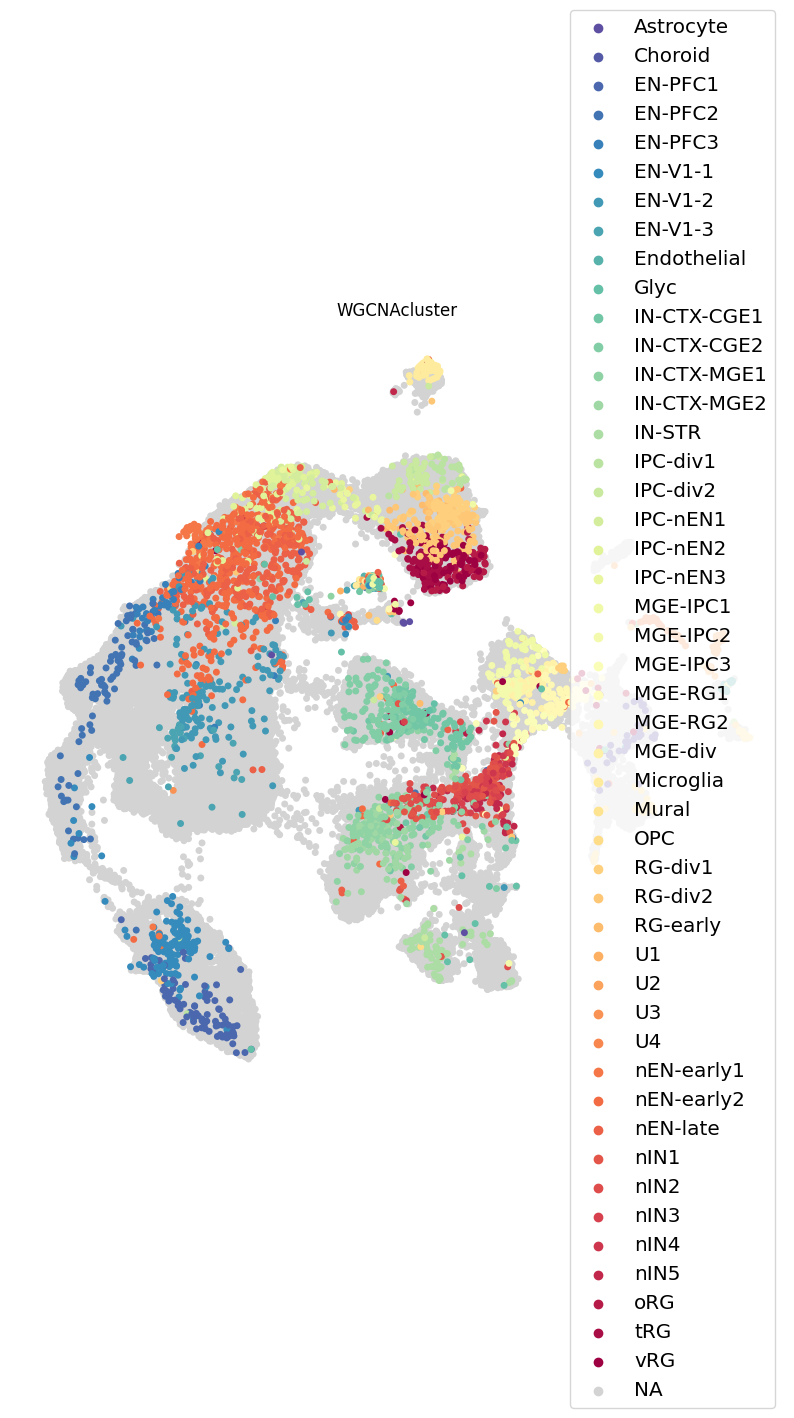

In [31]:
plt.rcParams['figure.figsize'] =10,10
sc.pl.umap(
    adata,
   # basis="X_mde",
    color=['WGCNAcluster'],
    frameon=False,
    ncols=2,
    s=100,
    palette='Spectral_r',
    legend_fontsize="x-large",
 #   save='_SCANVI_label_transfer_1'
    legend_loc='right'
    

    
)

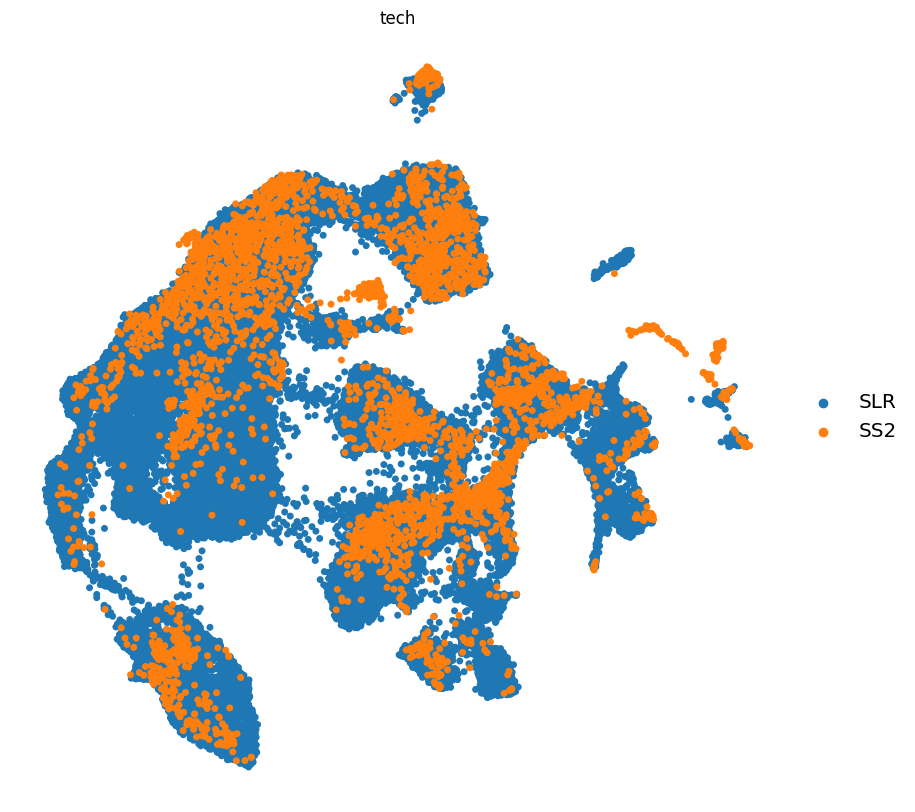

In [32]:
plt.rcParams['figure.figsize'] =10,10
sc.pl.umap(
    adata,
   # basis="X_mde",
    color=["tech"],
    frameon=False,
    ncols=2,
    s=100,
    palette=['tab:blue','tab:orange'],
    legend_fontsize="x-large",
    save='_SCANVI_label_transfer_2'

    
)

In [33]:
adata.obs["celltype_scanvi"] = 'Unknown'

In [34]:
ss2_mask = adata.obs['tech'] == "SS2"

In [35]:
adata.obs["celltype_scanvi"][ss2_mask] = adata.obs.WGCNAcluster[ss2_mask].values

/scratch/derek/ipykernel_3790177/4108648578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["celltype_scanvi"][ss2_mask] = adata.obs.WGCNAcluster[ss2_mask].values


In [36]:
adata.obs["celltype_scanvi"] = adata.obs["celltype_scanvi"].astype('str')

In [37]:
np.unique(adata.obs["celltype_scanvi"], return_counts = True)

(array(['Astrocyte', 'Choroid', 'EN-PFC1', 'EN-PFC2', 'EN-PFC3', 'EN-V1-1',
        'EN-V1-2', 'EN-V1-3', 'Endothelial', 'Glyc', 'IN-CTX-CGE1',
        'IN-CTX-CGE2', 'IN-CTX-MGE1', 'IN-CTX-MGE2', 'IN-STR', 'IPC-div1',
        'IPC-div2', 'IPC-nEN1', 'IPC-nEN2', 'IPC-nEN3', 'MGE-IPC1',
        'MGE-IPC2', 'MGE-IPC3', 'MGE-RG1', 'MGE-RG2', 'MGE-div',
        'Microglia', 'Mural', 'OPC', 'RG-div1', 'RG-div2', 'RG-early',
        'U1', 'U2', 'U3', 'U4', 'Unknown', 'nEN-early1', 'nEN-early2',
        'nEN-late', 'nIN1', 'nIN2', 'nIN3', 'nIN4', 'nIN5', 'nan', 'oRG',
        'tRG', 'vRG'], dtype=object),
 array([   46,    14,    93,    96,    53,   166,   182,    76,    30,
           77,   148,   153,   192,    95,    83,    36,    51,    68,
           76,    39,    44,    62,    40,    44,    70,    57,    77,
           19,    37,   133,   124,    53,    80,    27,    28,    56,
        75666,    52,   455,   321,    72,    96,    54,    28,    64,
          132,    65,   100,    97]))

In [38]:
adata

AnnData object with n_obs × n_vars = 79927 × 2000
    obs: 'n_counts', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden', 'scANVI_simple', 'tech', 'WGCNAcluster', 'Name', 'Age_in_Weeks', 'RegionName', 'Laminae', 'Area', 'celltype_scanvi'
    var: 'mito-SLR', 'n_cells_by_counts-SLR', 'mean_counts-SLR', 'log1p_mean_counts-SLR', 'pct_dropout_by_counts-SLR', 'total_counts-SLR', 'log1p_total_counts-SLR', 'ensemble_ID-SS2', 'data-SS2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'WGCNAcluster_colors', 'tech_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [39]:
# lvae = scvi.model.SCANVI.from_scvi_model(
#     vae,
#     adata=adata,
#     unlabeled_category="Unknown",
#     labels_key="celltype_scanvi",
# )

In [40]:
# lvae.train(max_epochs=20,
#            n_samples_per_label=100,
   
#           )

In [41]:
# lvae.save('./SCANVI_outs/LVAE/',
#          prefix='LVAE_v2')

In [42]:
lvae = scvi.model.SCANVI.load('/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/SCANVI_outs/LVAE/LVAE_v2',
                              adata)



INFO     File /c4/home/derek/data1/derek/data_scSLR/prenatal_brain/SCANVI_outs/LVAE/LVAE_v2/model.pt already       
         downloaded                                                                                                


/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/si ...


In [43]:
#adata.obs["C_scANVI"] = lvae.predict(adata)

#remove NAN as C_scANVI category
adata.obs["C_scANVI"] = lvae.predict(adata, soft=True).drop(['nan'],axis=1).idxmax(axis=1)

In [44]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [45]:

sc.pp.neighbors(adata,
                use_rep="X_scVI",
               # n_pcs=30,
               # n_neighbors=15
               )

sc.tl.umap(adata,
           # n_components=2,     
            min_dist =.4,
           # spread =2
          )

In [46]:
# in order to make colors matchup
adata.obs.C_scANVI = pd.Categorical(
                        adata.obs.C_scANVI.values,
                        categories=adata.obs.WGCNAcluster.cat.categories
)

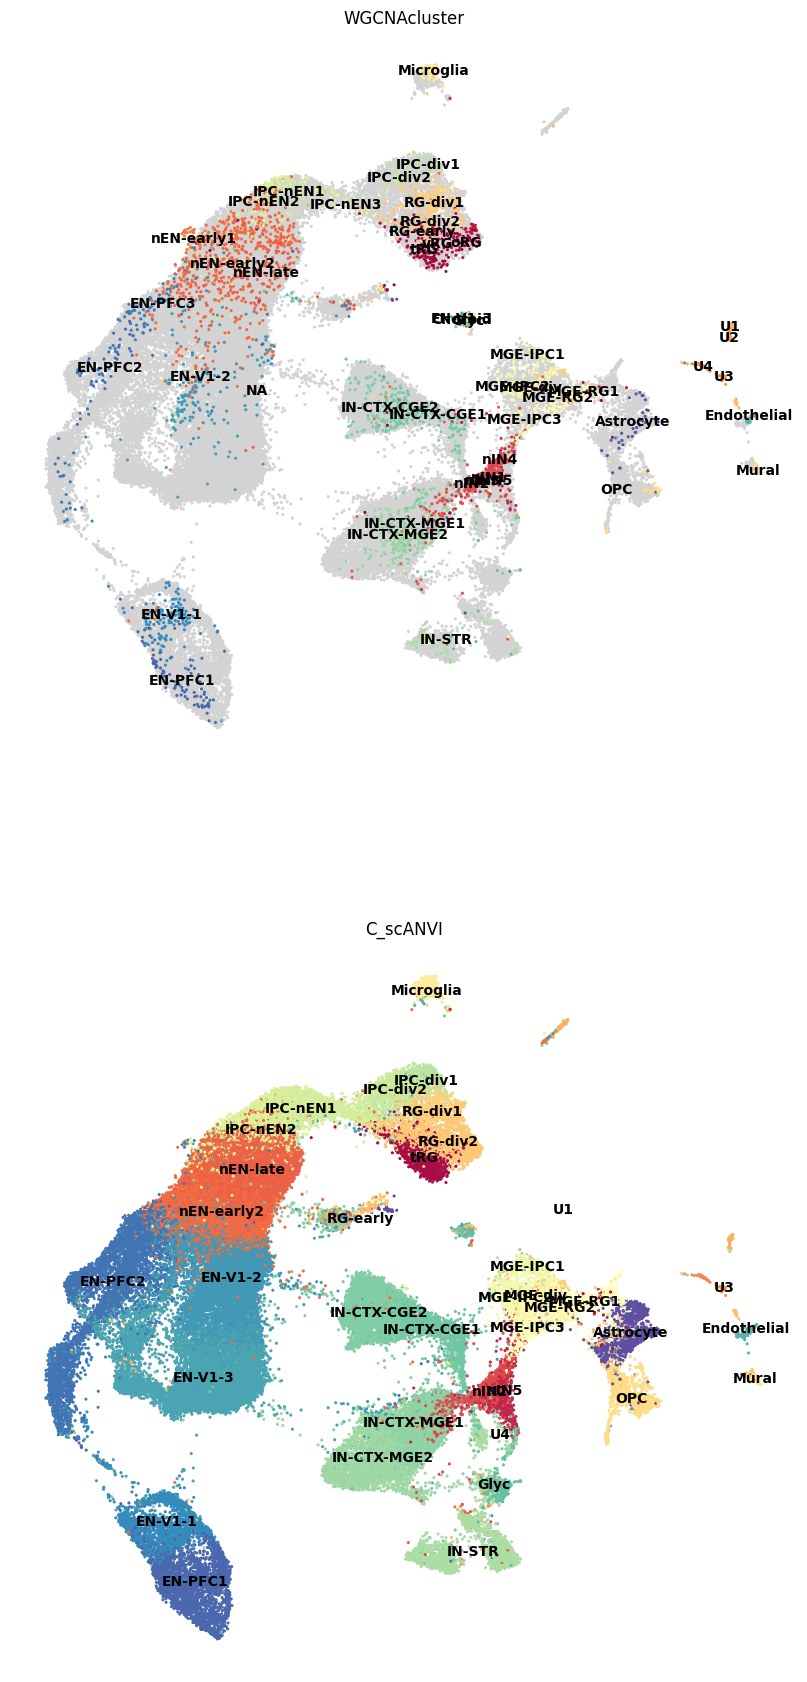

In [47]:
plt.rcParams['figure.figsize'] =10,10
sc.pl.umap(
    adata,
    #basis="X_mde_scanvi",
    color=[
           "WGCNAcluster",
           "C_scANVI"
    ],
    ncols=1,
    frameon=False,
    palette=adata.uns["WGCNAcluster_colors"],
    s=20,
    legend_loc = 'on data'
)

In [114]:
df

C_scANVI,Astrocyte,Choroid,EN-PFC1,EN-PFC2,EN-PFC3,EN-V1-1,EN-V1-2,EN-V1-3,Endothelial,Glyc,...,nEN-early2,nEN-late,nIN1,nIN2,nIN3,nIN4,nIN5,oRG,tRG,vRG
WGCNAcluster,,,,,,,,,,,,,,,,,,,,,
Astrocyte,42,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
Choroid,0,0,0,0,0,0,0,0,1,10,...,0,0,0,0,0,0,0,0,0,0
EN-PFC1,0,0,92,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
EN-PFC2,0,0,0,92,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
EN-PFC3,0,0,0,25,0,0,5,1,0,2,...,18,1,0,0,0,0,0,0,0,0
EN-V1-1,0,0,3,3,0,153,0,0,0,4,...,0,0,0,1,0,0,0,0,0,0
EN-V1-2,1,0,0,3,0,0,153,6,0,3,...,13,0,0,0,0,0,0,0,0,0
EN-V1-3,0,0,0,0,0,0,1,74,0,1,...,0,0,0,0,0,0,0,0,0,0
Endothelial,0,0,0,0,0,0,0,0,30,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df = adata.obs.groupby(["WGCNAcluster", "C_scANVI"]).size().unstack(fill_value=0)

In [49]:
conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

Text(0, 0.5, 'Observed')

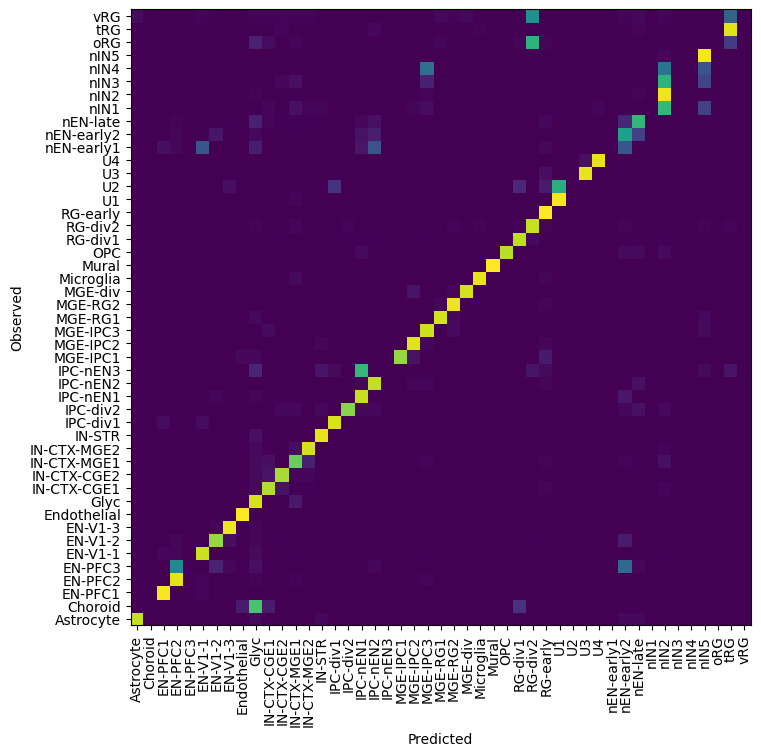

In [50]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

# plt.savefig('./plots/SCANVI_matrix.pdf')

<Axes: xlabel='C_scANVI', ylabel='WGCNAcluster'>

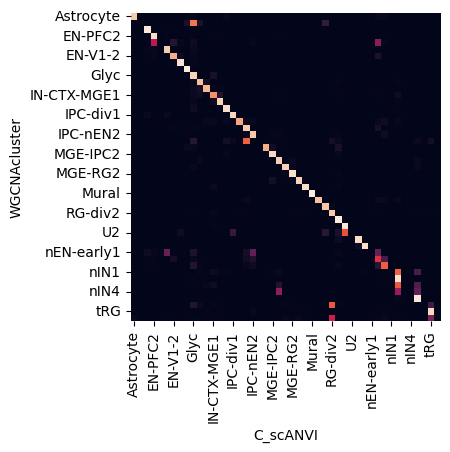

In [54]:
fig, ax = plt.subplots(figsize=(4,4))

sns.heatmap(conf_mat, cbar=False)

In [ ]:
plt.figure(figsize=(8, 8))
_ = plt.pcolor(conf_mat)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

# plt.savefig('./plots/SCANVI_matrix.pdf')

In [63]:
lut = dict(zip(adata.obs['WGCNAcluster'].cat.categories, adata.uns["WGCNAcluster_colors"]))

In [118]:
col_colors= conf_mat.iloc[::-1].columns.map(lut)
row_colors= conf_mat.iloc[::-1].index.map(lut)

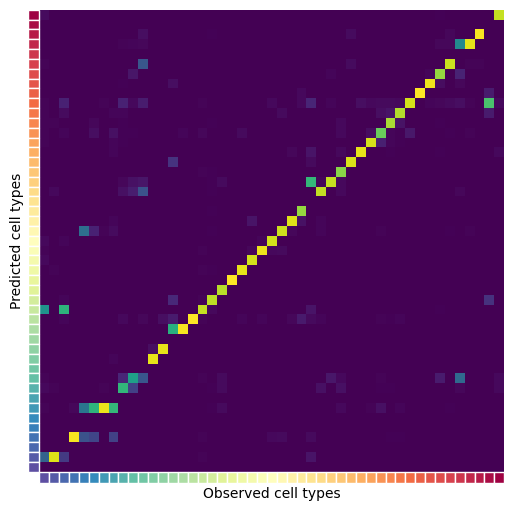

In [120]:
fig, ax = plt.subplots(figsize=(6,6))

ax = sns.heatmap(conf_mat.iloc[::-1].T, cbar=False, cmap='viridis', linewidths=0.001)

ax.tick_params(bottom=False, left=False) 
ax.set_yticklabels([])
ax.set_xticklabels([])

for i, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.025, i), width=0.025, height=1, facecolor=color, lw=1, edgecolor='w',
                               transform=ax.get_yaxis_transform(), clip_on=False))

for i, color in enumerate(col_colors):
    ax.add_patch(plt.Rectangle(xy=(i, -0.025), width=1, height=0.025, facecolor=color, lw=1, edgecolor='w',
                               transform=ax.get_xaxis_transform(), clip_on=False))

ax.set(xlabel='Observed cell types')
ax.set(ylabel='Predicted cell types')

fig.savefig('./plots/SCVI_label_transfer_predictions.pdf')


C_scANVI,Astrocyte,Choroid,EN-PFC1,EN-PFC2,EN-PFC3,EN-V1-1,EN-V1-2,EN-V1-3,Endothelial,Glyc,...,nEN-early2,nEN-late,nIN1,nIN2,nIN3,nIN4,nIN5,oRG,tRG,vRG
WGCNAcluster,,,,,,,,,,,,,,,,,,,,,
vRG,0.030928,0.0,0.000000,0.000000,0.0,0.010309,0.000000,0.000000,0.000000,0.010309,...,0.010309,0.020619,0.0,0.010309,0.0,0.0,0.000000,0.0,0.309278,0.0
tRG,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.950000,0.0
oRG,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.092308,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.169231,0.0
nIN5,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.015625,0.0,0.0,0.984375,0.0,0.000000,0.0
nIN4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.392857,0.0,0.0,0.250000,0.0,0.000000,0.0
nIN3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.648148,0.0,0.0,0.203704,0.0,0.000000,0.0
nIN2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.010417,...,0.000000,0.010417,0.0,0.968750,0.0,0.0,0.000000,0.0,0.000000,0.0
nIN1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.666667,0.0,0.0,0.194444,0.0,0.000000,0.0
nEN-late,0.000000,0.0,0.000000,0.009346,0.0,0.000000,0.003115,0.006231,0.000000,0.090343,...,0.109034,0.657321,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0


In [62]:
ad_labels = adata[adata.obs['tech'] == 'SLR']
ad_labels.obs_names = ad_labels.obs_names.str[:-4]
adata_SLR.obs['C_scANVI'] = ad_labels.obs['C_scANVI']

In [63]:
#remove doublet/low-qual
adata_SLR = adata_SLR[~adata_SLR.obs.leiden.isin(['23','27','30'])]

In [64]:
adata_SLR

View of AnnData object with n_obs × n_vars = 75666 × 36385
    obs: 'n_counts', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_mito', '_scvi_batch', '_scvi_labels', 'leiden', 'scANVI_simple', 'tech', 'C_scANVI'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [49]:
##simplify celltype categories

In [50]:
cat_list = adata.obs.C_scANVI.cat.categories.tolist()

In [51]:
dict(zip(cat_list, cat_list))

{'Astrocyte': 'Astrocyte',
 'Choroid': 'Choroid',
 'EN-PFC1': 'EN-PFC1',
 'EN-PFC2': 'EN-PFC2',
 'EN-PFC3': 'EN-PFC3',
 'EN-V1-1': 'EN-V1-1',
 'EN-V1-2': 'EN-V1-2',
 'EN-V1-3': 'EN-V1-3',
 'Endothelial': 'Endothelial',
 'Glyc': 'Glyc',
 'IN-CTX-CGE1': 'IN-CTX-CGE1',
 'IN-CTX-CGE2': 'IN-CTX-CGE2',
 'IN-CTX-MGE1': 'IN-CTX-MGE1',
 'IN-CTX-MGE2': 'IN-CTX-MGE2',
 'IN-STR': 'IN-STR',
 'IPC-div1': 'IPC-div1',
 'IPC-div2': 'IPC-div2',
 'IPC-nEN1': 'IPC-nEN1',
 'IPC-nEN2': 'IPC-nEN2',
 'IPC-nEN3': 'IPC-nEN3',
 'MGE-IPC1': 'MGE-IPC1',
 'MGE-IPC2': 'MGE-IPC2',
 'MGE-IPC3': 'MGE-IPC3',
 'MGE-RG1': 'MGE-RG1',
 'MGE-RG2': 'MGE-RG2',
 'MGE-div': 'MGE-div',
 'Microglia': 'Microglia',
 'Mural': 'Mural',
 'OPC': 'OPC',
 'RG-div1': 'RG-div1',
 'RG-div2': 'RG-div2',
 'RG-early': 'RG-early',
 'U1': 'U1',
 'U2': 'U2',
 'U3': 'U3',
 'U4': 'U4',
 'nEN-early1': 'nEN-early1',
 'nEN-early2': 'nEN-early2',
 'nEN-late': 'nEN-late',
 'nIN1': 'nIN1',
 'nIN2': 'nIN2',
 'nIN3': 'nIN3',
 'nIN4': 'nIN4',
 'nIN5': 'nIN5'

In [52]:
simplify_dict = {'Astrocyte': 'Astrocyte',
 'Choroid': 'Choroid',
 'EN-PFC1': 'EN-PFC',
 'EN-PFC2': 'EN-PFC',
 'EN-PFC3': 'EN-PFC',
 'EN-V1-1': 'EN-V1',
 'EN-V1-2': 'EN-V1',
 'EN-V1-3': 'EN-V1',
 'Endothelial': 'Endothelial',
 'Glyc': 'Glyc',
 'IN-CTX-CGE1': 'IN-CTX-CGE',
 'IN-CTX-CGE2': 'IN-CTX-CGE',
 'IN-CTX-MGE1': 'IN-CTX-MGE',
 'IN-CTX-MGE2': 'IN-CTX-MGE',
 'IN-STR': 'IN-STR',
 'IPC-div1': 'IPC-div',
 'IPC-div2': 'IPC-div',
 'IPC-nEN1': 'IPC-nEN',
 'IPC-nEN2': 'IPC-nEN',
 'IPC-nEN3': 'IPC-nEN',
 'MGE-IPC1': 'MGE-IPC',
 'MGE-IPC2': 'MGE-IPC',
 'MGE-IPC3': 'MGE-IPC',
 'MGE-RG1': 'MGE-RG',
 'MGE-RG2': 'MGE-RG',
 'MGE-div': 'MGE-div',
 'Microglia': 'Microglia',
 'Mural': 'Mural',
 'OPC': 'OPC',
 'RG-div1': 'RG-div',
 'RG-div2': 'RG-div',
 'RG-early': 'RG',
 'U1': 'U1',
 'U2': 'U2',
 'U3': 'U3',
 'U4': 'U4',
 'nEN-early1': 'nEN',
 'nEN-early2': 'nEN',
 'nEN-late': 'nEN',
 'nIN1': 'nIN',
 'nIN2': 'nIN',
 'nIN3': 'nIN',
 'nIN4': 'nIN',
 'nIN5': 'nIN',
 'oRG': 'oRG',
 'tRG': 'RG',
 'vRG': 'vRG'}

In [53]:
adata.obs['C_scANVI_simple'] = adata.obs.C_scANVI.map(simplify_dict)

/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


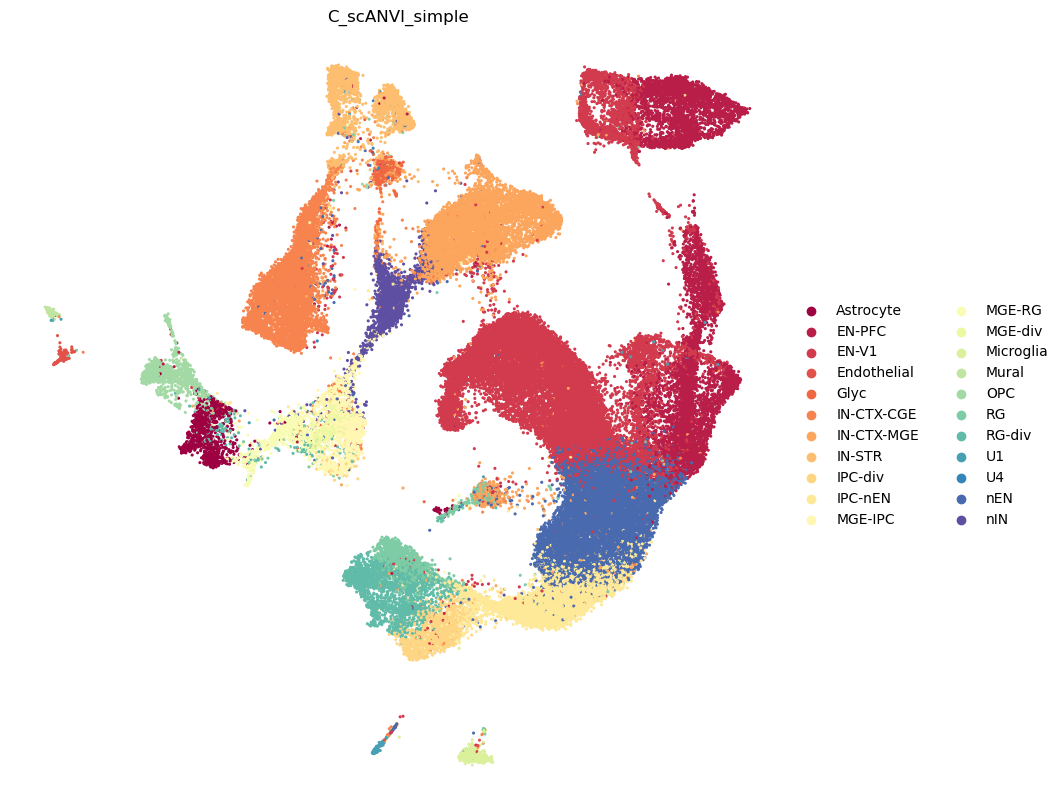

In [54]:
plt.rcParams['figure.figsize'] =10,10
sc.pl.umap(
    adata[adata.obs['tech'] == "SLR"],
   # basis="X_mde_scanvi",
    color=[
        "C_scANVI_simple",
    ],
    ncols=1,
    frameon=False,
    palette="Spectral",
    s=20
)

In [55]:
adata[adata.obs['tech'] == "SLR"].obs['C_scANVI_simple'].value_counts()

EN-V1          18858
nEN            14324
EN-PFC          8381
IN-CTX-MGE      7608
IN-CTX-CGE      6509
IPC-nEN         5240
IN-STR          2157
RG-div          2121
nIN             1814
RG              1464
IPC-div         1310
MGE-IPC         1300
OPC             1135
Astrocyte       1074
MGE-RG           705
Glyc             481
Microglia        351
MGE-div          259
U1               236
Endothelial      137
Mural            134
U4                68
Name: C_scANVI_simple, dtype: int64

In [56]:
ad_labels = adata[adata.obs['tech'] == 'SLR']
ad_labels.obs_names = ad_labels.obs_names.str[:-4]
adata_SLR.obs['C_scANVI_simple'] = ad_labels.obs['C_scANVI_simple']

/tmp/ipykernel_2885857/4145636165.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SLR.obs['C_scANVI_simple'] = ad_labels.obs['C_scANVI_simple']


In [57]:
sc.tl.leiden(adata_SLR,resolution=1.5)

/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


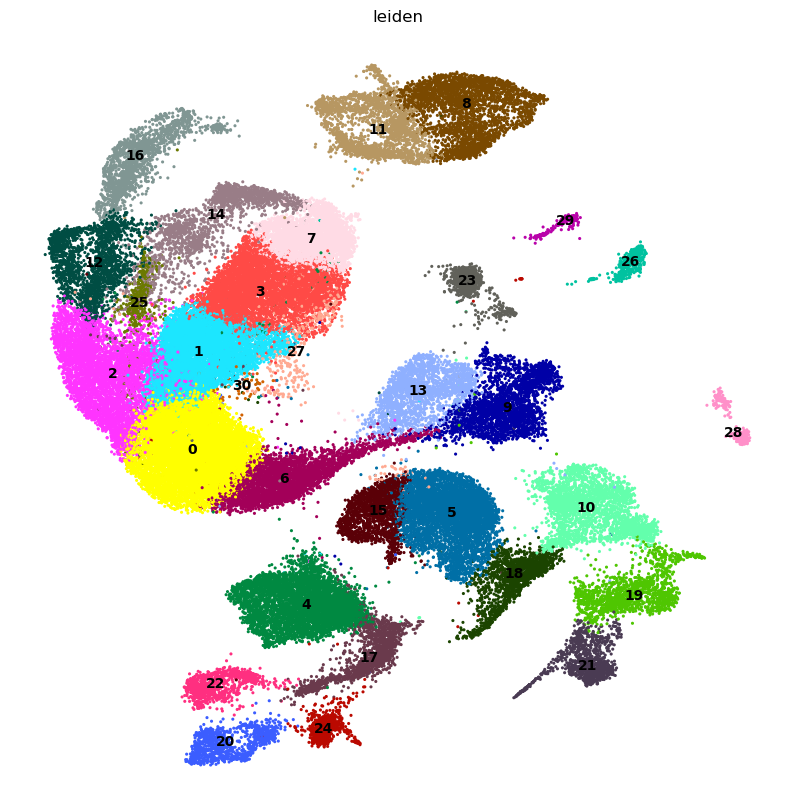

In [58]:
plt.rcParams['figure.figsize'] =10,10
sc.pl.umap(
    adata_SLR,
    color=['leiden',
    ],
    ncols=1,
    frameon=False,
    s=20,
    legend_loc = 'on data',

)

In [59]:
#remove low quality/doublets
adata_SLR = adata_SLR[~adata_SLR.obs['leiden'].isin(['23','27','30'])]

In [60]:
sc.tl.rank_genes_groups(adata,
                        use_raw=True,
                        groupby='C_scANVI_simple',
                        groups=['U1'],
                        reference='rest'
                       )
                            

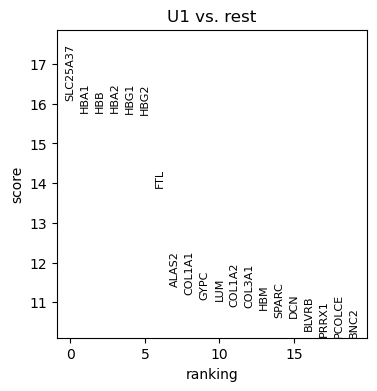

In [61]:
plt.rcParams['figure.figsize'] =4,4

sc.pl.rank_genes_groups(adata)

In [62]:
adata_SLR.obs['C_scANVI_simple'] = adata_SLR.obs.C_scANVI_simple.replace('U1','RBC')

/tmp/ipykernel_2885857/139259883.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_SLR.obs['C_scANVI_simple'] = adata_SLR.obs.C_scANVI_simple.replace('U1','RBC')


In [63]:
sc.tl.rank_genes_groups(adata,
                        use_raw=True,
                        groupby='C_scANVI_simple',
                        groups=['U4'],
                        reference='Glyc'
                       )
                          

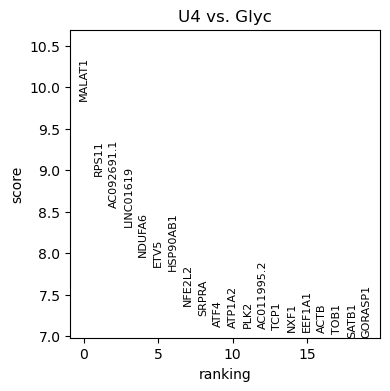

In [64]:
plt.rcParams['figure.figsize'] =4,4

sc.pl.rank_genes_groups(adata)

In [65]:
adata_SLR.obs['C_scANVI_simple'] = adata_SLR.obs.C_scANVI_simple.replace('U4','Glyc')

/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


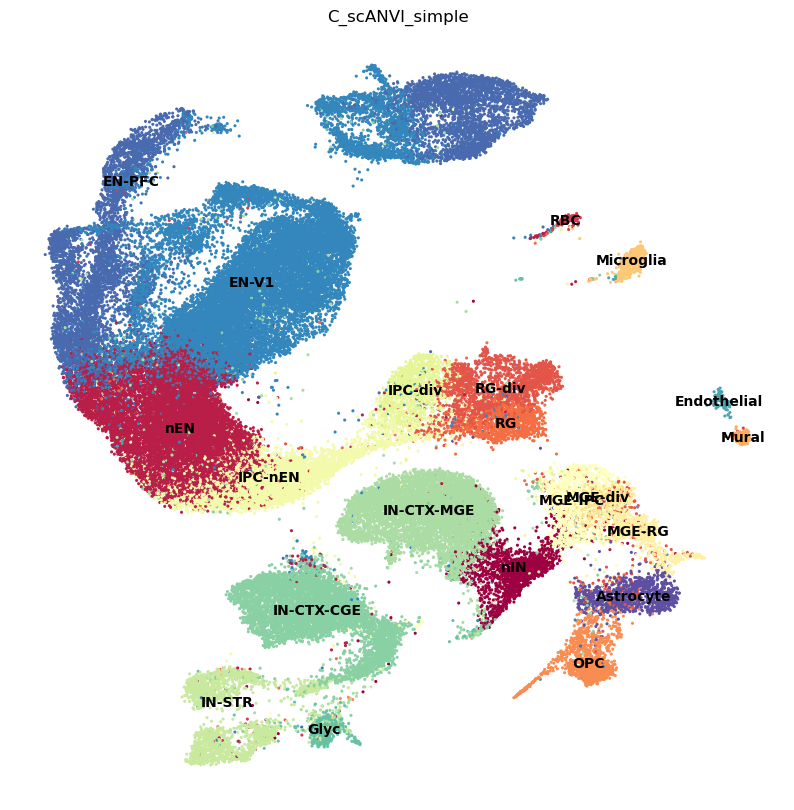

In [66]:
plt.rcParams['figure.figsize'] =10,10
sc.pl.umap(
    adata_SLR,
    color=['C_scANVI_simple',
    ],
    ncols=1,
    frameon=False,
    palette='Spectral_r',
    s=20,
    legend_loc = 'on data',

)

In [67]:
adata_SLR.obs.batch

AAACCCAAGAACCGCA-0    0
AAACCCAAGCAACAGC-0    0
AAACCCAAGCCTGGAA-0    0
AAACCCACAAACCACT-0    0
AAACCCACACCAGCCA-0    0
                     ..
TTTGTTGTCCGTAGTA-5    5
TTTGTTGTCCTGTTGC-5    5
TTTGTTGTCTCAAAGC-5    5
TTTGTTGTCTGTAAGC-5    5
TTTGTTGTCTTACCAT-5    5
Name: batch, Length: 74327, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', '5']

In [68]:
#write out barcode lists

# pd.DataFrame(adata_SLR[adata_SLR.obs.batch == '0'].obs_names.str[:-2]).to_csv('GW16_1_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata_SLR[adata_SLR.obs.batch == '1'].obs_names.str[:-2]).to_csv('GW16_2_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata_SLR[adata_SLR.obs.batch == '2'].obs_names.str[:-2]).to_csv('GW17_1_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata_SLR[adata_SLR.obs.batch == '3'].obs_names.str[:-2]).to_csv('GW21_1_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata_SLR[adata_SLR.obs.batch == '4'].obs_names.str[:-2]).to_csv('GW21_2_barcodes.csv',header=None,index=None)
# pd.DataFrame(adata_SLR[adata_SLR.obs.batch == '5'].obs_names.str[:-2]).to_csv('GW23_1_barcodes.csv',header=None,index=None)

In [69]:
#adata_SLR.write_h5ad('scANVI_label.h5ad')

In [70]:
# pd.DataFrame(adata_SLR.obs['C_scANVI_simple']
#             ).set_index(adata_SLR.obs_names,drop=True).to_csv('scANVI_annotations_v2.csv')

/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


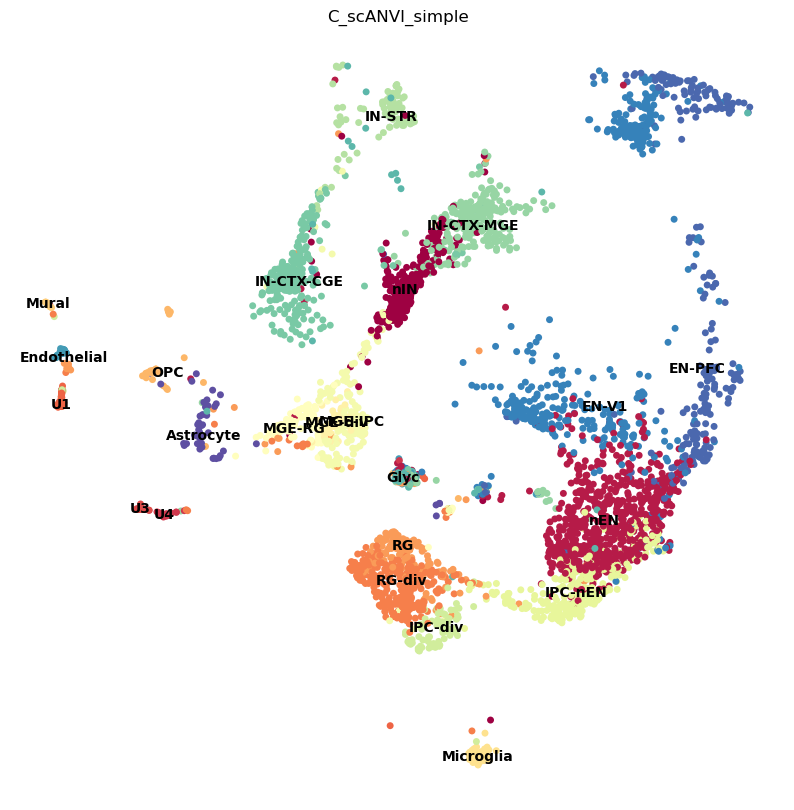

In [101]:
sc.pl.umap(adata[adata.obs.tech == 'SS2'],
           color=['C_scANVI_simple',
    ],
    ncols=1,
    frameon=False,
    palette='Spectral_r',
    s=100,
    legend_loc = 'on data',)
           

In [72]:
ad_ss = adata[adata.obs.tech == 'SS2']

In [73]:
ad_ss.obs['C_scANVI_simple'] = ad_ss.obs.C_scANVI_simple.replace('U1','RBC')
ad_ss.obs['C_scANVI_simple'] = ad_ss.obs.C_scANVI_simple.replace('U4','Glyc')

/tmp/ipykernel_2885857/2846994856.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_ss.obs['C_scANVI_simple'] = ad_ss.obs.C_scANVI_simple.replace('U1','RBC')


Index(['Hi_GW16_1-Hi_GW16_1-SS2', 'Hi_GW16_10-Hi_GW16_10-SS2',
       'Hi_GW16_11-Hi_GW16_11-SS2', 'Hi_GW16_12-Hi_GW16_12-SS2',
       'Hi_GW16_13-Hi_GW16_13-SS2', 'Hi_GW16_14-Hi_GW16_14-SS2',
       'Hi_GW16_15-Hi_GW16_15-SS2', 'Hi_GW16_16-Hi_GW16_16-SS2',
       'Hi_GW16_17-Hi_GW16_17-SS2', 'Hi_GW16_18-Hi_GW16_18-SS2',
       ...
       'S96-G10-SS2', 'S96-G11-SS2', 'S96-G2-SS2', 'S96-G4-SS2', 'S96-G5-SS2',
       'S96-G6-SS2', 'S96-G9-SS2', 'S96-H11-SS2', 'S96-H2-SS2', 'S96-H3-SS2'],
      dtype='object', length=4261)

In [107]:
SS2_tsne = pd.read_csv('/home/derek/analysis_11/NOW_2017/cell_browser_files/tMinusSNE_on_WGCNA.coords.tsv.gz',sep='\t',header=None,index_col=0)
SS2_tsne.index.name = None

In [108]:
SS2_tsne.index = SS2_tsne.index.str.replace('.','-')
SS2_tsne.index = SS2_tsne.index + '-SS2'

/tmp/ipykernel_2885857/219512122.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  SS2_tsne.index = SS2_tsne.index.str.replace('.','-')


In [119]:
SS2_tsne = SS2_tsne.reindex(ad_ss.obs_names)

In [120]:
ad_ss.obsm['X_tsne'] = SS2_tsne.to_numpy()

/home/derek/miniconda3/envs/SCVI_2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


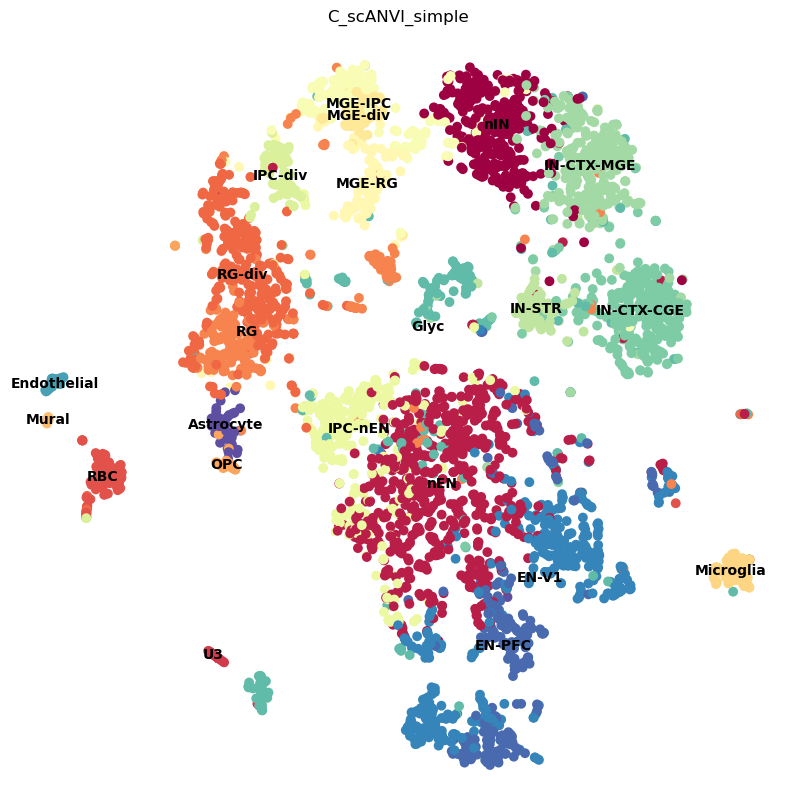

In [126]:
sc.pl.tsne(ad_ss,
           color=['C_scANVI_simple'],
    ncols=1,
    frameon=False,
    palette='Spectral_r',
    s=200,
    legend_loc = 'on data',
          )
          

In [74]:
pd.DataFrame(ad_ss.obs['C_scANVI_simple']
            ).set_index(ad_ss.obs_names,drop=True).to_csv('scANVI_annotations_SS2_v2.csv')

In [123]:
ad_ss.write_h5ad('SS2_scANVI_label.h5ad')

In [75]:
!conda list

# packages in environment at /home/derek/miniconda3/envs/SCVI_2:
#
# Name                    Version                   Build  Channel
_ipython_minor_entry_point 8.7.0                h8cf3c4a_0    conda-forge
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   1.2.0                    pypi_0    pypi
aiohttp                   3.8.1                    pypi_0    pypi
aiosignal                 1.2.0                    pypi_0    pypi
altair                    4.2.0              pyhd8ed1ab_1    conda-forge
anndata                   0.8.0              pyhd8ed1ab_1    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
aom                       3.5.0                h27087fc_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hb9d737c_3    conda-forge
asttokens 